In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import time

## Guided Example

__Goal:__ Predict a recipe's rating from ingredient and keyword list

__Dataset:__ [Epicurious Recipes](https://www.kaggle.com/hugodarwood/epirecipes)

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
#list(raw_data.columns)
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

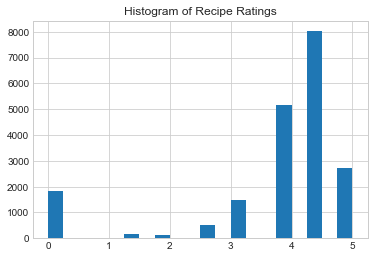

In [4]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

__Result:__ 
- There are ~20,000 recipes with an average rating of 3.71
- 25th percentile is above the mean; likely outlier population (very low reviews on bad recipes)
- Data is not continuous, no recipe has a 3.5 rating
- Increase of count at 0 rating

In [5]:
#data cleaning
#count nulls
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [6]:
#lots of missing nutrition info, drop these columns
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating','title','calories','protein','fat','sodium'], 1)
Y = raw_data.rating

#uncomment below to run svm (might take a while)
start_time = time.clock()
svr.fit(X,Y)
print('\nruntime:\n',time.clock() - start_time, "seconds")


runtime:
 303.601349 seconds


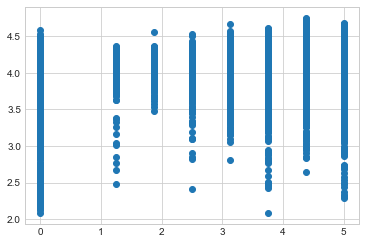


runtime:
 297.26082199999996 seconds


In [7]:
#uncomment below to run svm (might take a while)
start_time = time.clock()
plt.scatter(Y, svr.predict(X))
plt.show()
print('\nruntime:\n',time.clock() - start_time, "seconds")

In [8]:
#uncomment below to run svm (might take a while)
start_time = time.clock()
print(svr.score(X,Y))
print('\nruntime:\n',time.clock() - start_time, "seconds")

0.03856570651298896

runtime:
 304.2036250000001 seconds


In [9]:
from sklearn.model_selection import cross_val_score

#uncomment below to run svm (might take a while)
start_time = time.clock()
print(cross_val_score(svr,X,Y,cv=5))
print('\nruntime:\n',time.clock() - start_time, "seconds")

[0.01818511 0.026411   0.03037705 0.01957949 0.02451197]

runtime:
 1216.1912419999999 seconds


__Results:__ these are not good results
- Poor accuracy
- Overfitting

## Challenge
- Transform this regression problem into a binary classifier
- Clean up the feature set and cut down to 30 most valuable features

### Baseline results to beat

In [10]:
#uncomment below to run svm (might take a while)
start_time = time.clock()
scores_svr = cross_val_score(svr,X,Y,cv=5)

print('score array:\n', scores_svr)
print('\nscore array mean:\n', np.mean(scores_svr))
print('\nscore array std dev:\n', np.std(scores_svr))
print('\nruntime:\n',time.clock() - start_time, "seconds")

score array:
 [0.01818511 0.026411   0.03037705 0.01957949 0.02451197]

score array mean:
 0.02381292426673918

score array std dev:
 0.004470362733536093

runtime:
 1234.3788949999998 seconds


In [11]:
#set new df to play with
df = raw_data.drop(['calories','protein','fat','sodium'], 1)
#df.head()

### Transform rating variable to binary

Split rating variable
- high ratings: $rating>=4,=1$
- all else: $rating<4,=0$

In [12]:
#transform rating variable to binary
# *** ONLY RUN THIS CELL ONCE ***
df['rating'] = df['rating'].map(lambda x: 1 if x >= 2.5 else 0)
df['rating'].value_counts()

1    17928
0     2124
Name: rating, dtype: int64

### Feature selection, first attempt
See how simply selecting the 30 most commonly mentioned ingredients/keywords/phrases work as features

In [13]:
#get top 30 keywords by number of mentions
top_keywords = df.drop(['rating','title'],1)
top_keywords = top_keywords.apply(pd.Series.value_counts).transpose()
top_keywords = top_keywords.reset_index()
top_keywords.columns = ['keywords', '0', '1']
top_keywords = top_keywords.sort_values(by='1', ascending=False)
top_keywords = top_keywords.head(30)

#put top keywords into list
top_keys_list = list(top_keywords.keywords)

In [14]:
#fit vanilla svc (C=1, kernel='rbf)
from sklearn.svm import SVC
svc = SVC()
X1 = df[top_keys_list]
Y1 = df.rating

#uncomment below to run svm (might take a while)
start_time = time.clock()
svc.fit(X1,Y1)
scores_svc = cross_val_score(svc,X1,Y1,cv=5)

print('score array:\n', scores_svc)
print('\nscore array mean:\n', np.mean(scores_svc))
print('\nscore array std dev:\n', np.std(scores_svc))
print('\nruntime:\n',time.clock() - start_time, "seconds")

score array:
 [0.89404139 0.89404139 0.89404139 0.89401496 0.89423796]

score array mean:
 0.8940754171474323

score array std dev:
 8.191549234149359e-05

runtime:
 57.43781200000012 seconds


In [15]:
#try other c values and kernels
from sklearn.model_selection import GridSearchCV

params = [{'C': [0.01, 0.1, 1, 10], 'kernel':['linear']},
          {'C': [0.01, 0.1, 1, 10], 'kernel':['poly']},
          {'C': [0.01, 0.1, 1, 10], 'kernel':['rbf']},
          {'C': [0.01, 0.1, 1, 10], 'kernel':['sigmoid']}]

grid = GridSearchCV(estimator=svc, param_grid=params)

#uncomment below to run svm (might take a while)
start_time = time.clock()
grid.fit(X1,Y1)
print('\nBest parameters:\n', grid.best_params_)
print('\nBest score:\n', grid.best_score_)
print('\nruntime:\n',time.clock() - start_time, "seconds")

In [16]:
#best result was from default rbf kernel with c=10
svc1 = SVC(C=10)

#uncomment below to run svm (might take a while)
start_time = time.clock()
svc1.fit(X1,Y1)
scores_svc1 = cross_val_score(svc1,X1,Y1,cv=5)

print('score array:\n', scores_svc1)
print('\nscore array mean:\n', np.mean(scores_svc1))
print('\nscore array std dev:\n', np.std(scores_svc1))
print('\nruntime:\n',time.clock() - start_time, "seconds")

score array:
 [0.89404139 0.89404139 0.89404139 0.89401496 0.89423796]

score array mean:
 0.8940754171474323

score array std dev:
 8.191549234149359e-05

runtime:
 113.22913500000004 seconds


__Result:__ Much improved (and much much faster) over the initial svr model, std dev is high and there is room to improve accuracy

### Feature selection, second attempt

__SelectKBest:__ Someone on slack mentioned this for feature selection, try it out here

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

#data & target
X2 = df.drop(['title','rating'],1)
Y2 = df.rating

#use f val for kbest, fit SVC
f_vals = SelectKBest(f_classif, k=30)
svc2 = SVC()
svc2_f = make_pipeline(f_vals, svc2)

#uncomment below to run svm (might take a while)
start_time = time.clock()
svc2_f.fit(X2,Y2)
scores_svc2 = cross_val_score(svc2_f,X2,Y2,cv=5)

print('score array:\n', scores_svc2)
print('\nscore array mean:\n', np.mean(scores_svc2))
print('\nscore array std dev:\n', np.std(scores_svc2))
print('\nruntime:\n',time.clock() - start_time, "seconds")

score array:
 [0.90251808 0.90401396 0.90251808 0.90224439 0.9034672 ]

score array mean:
 0.9029523400043198

score array std dev:
 0.0006738673862570717

runtime:
 34.07910700000002 seconds


In [18]:
#see what features are selected
features = f_vals.get_support(indices=True)
feature_names = list(X2.columns)
features_kbest = []

for feature in features:
    features_kbest.append(feature_names[feature])

print(features_kbest)

['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink', 'fall', 'fortified wine', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lime juice', 'liqueur', 'non-alcoholic', 'peanut free', 'pernod', 'quick & easy', 'rum', 'sauté', 'soy free', 'spirit', 'tree nut free', 'weelicious', 'winter']


In [19]:
#try a linear kernel
svc_linear = SVC(kernel='linear')
svc_linear_f = make_pipeline(f_vals, svc_linear)

#uncomment below to run svm (might take a while)
start_time = time.clock()
svc_linear_f.fit(X2,Y2)
scores_svc_linear = cross_val_score(svc_linear_f,X2,Y2,cv=5)

print('score array:\n', scores_svc_linear)
print('\nscore array mean:\n', np.mean(scores_svc_linear))
print('\nscore array std dev:\n', np.std(scores_svc_linear))
print('\nruntime:\n',time.clock() - start_time, "seconds")

score array:
 [0.89852905 0.90102219 0.90027425 0.90099751 0.90097281]

score array mean:
 0.9003591594678925

score array std dev:
 0.000957098947632037

runtime:
 20.489469999999983 seconds


__Result:__ Slightly more accurate than first SVC, but much lower std dev and runs much quicker